# Dense Neural Network from Scratch

Authors: Jordan Conrad-Burton and Moshe Shem Tov

In [ ]:
!pip install torch torchvision

In [ ]:
import torch
import torchvision
import numpy as np
import math
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Introduction

This notebook demonstrates a full implementation of a dense neural network from scratch. It includes:

* Manual forward and backward propagation

* ReLU and Softmax activations

* Batch normalization

* L2 regularization

* Mini-batch gradient descent

* Application to the MNIST digit classification task

The network has four layers in addition to the input layer with the sizes: 20, 7, 5, 10, where the last layer is the classification output. We use a learning rate of 0.009 as per the assignment instructions.

We divide the training set into a training and validation set, using 20% of the original training set for validation. In addition, our stopping condition as per the assignment instructions is that we stop training when there has been no improvement on the validation set for 100 training steps, which we defined as the model training on a single batch.



## Activation Functions

In this network we use the **ReLU** (Rectified Linear Unit) and **Softmax** activation functions. Softmax is used on the last layer of neurons and ReLU is used on the rest.


#### ReLU

The ReLU function is commonly used in hidden layers because it introduces non-linearity while avoiding the vanishing gradient problem.

**Definition:** $ReLU(z)=max(0,z)$

#### Softmax

Softmax is used in the output layer for multi-class classification. It converts raw scores (logits) into probabilities.

**Definition:** $Softmax(z_i)=\frac{e^{z_i}}{\sum_j e^{z_j}}$

This ensures that all output values are between 0 and 1, and they sum to 1 — making them interpretable as probabilities.

## Loss Function: Categorical Cross-Entropy Loss

Used to measure the distance between the true labels and the predicted probabilities.

$ℒ(Y,Ŷ)=-∑_{i=1}^{C} y_ilog(ŷ_i)$

Where:

* C: Number of classes

* $y_i$: True label (1 for correct class, 0 otherwise)

* $ŷ_i$: Predicted probability for class $i$

## Batchnorm

Used to stabilize and accelerate training by normalizing the activations of each layer.

**Steps:**

1. Normalize the activation $A$ using:

      $μ=mean(A)$, $σ^2 = var(A)$

      $Â = \frac{A-\mu}{\sqrt{σ^2 + ϵ}}$

2. Optionally scale and shift $Â$ using learnable parameters $γ, β$

In this assignment, only normalization is used (no learnable scale/shift).

## L2 Regularization

Adds a penalty to the loss to discourage large weights and prevent overfitting.

**Modified Cost Function:**

$ℒ_{reg} = ℒ_{cross-entropy} + \frac{ϵ}{2m}∑_{l=1}^{L} ||W^{[l]}||_2^2$

In backpropagation, we add $\epsilon W^{[l]}$ to each weight gradient:

$$

## 1. Forward Propagation

In [ ]:
def initialize_parameters(layer_dims):
    """
    Initializes weights and biases for a fully connected neural network.

    Args:
        layer_dims: List containing the dimensions of each layer.

    Returns:
        parameter_dictionary: Dictionary containing initialized weights 'W1'...'WL' and biases 'b1'...'bL'.
    """
  parameter_dictionary = {}
  L = len(layer_dims)

  for l in range(1, L):
    initialized_W = np.random.randn(layer_dims[l], layer_dims[l - 1]).astype(np.double) * np.sqrt(2 / layer_dims[l - 1])
    initialized_b = np.zeros((layer_dims[l], 1), dtype=np.double)
    parameter_dictionary[l] = (initialized_W, initialized_b)

  return parameter_dictionary

In [ ]:
def linear_forward(A, W, b):
    """
    Implements the linear part of forward propagation for a single layer.

    Args:
        A: Activations from the previous layer (shape: previous_layer_size, m).
        W: Weights matrix (shape: current_layer_size, previous_layer_size).
        b: Bias vector (shape: current_layer_size, 1).

    Returns:
        Z: Linear component of the activation function.
        linear_cache: Cached values A, W, b for backward propagation.
    """

  A, W, b = A.double(), W.double(), b.double()
  linear_cache = {'A': A, 'W': W, 'b': b}
  Z = torch.matmul(W, A) + b

  return Z, linear_cache

In [ ]:
def softmax(Z):
    """
    Applies the softmax activation function.

    Args:
        Z: Linear input (pre-activation).

    Returns:
        A: Softmax probabilities.
        activation_cache: Cached Z for use in backward propagation.
    """
  activation_cache = {'Z': Z}

  exp_Z = torch.exp(Z)
  A = exp_Z / torch.sum(exp_Z, axis=0, keepdims=True)

  return A, activation_cache

In [ ]:
def relu(Z):
    """
    Applies ReLU activation function.

    Args:
        Z: Linear input (pre-activation).

    Returns:
        A: Post-activation output.
        activation_cache: Cached Z for use in backward propagation.
    """
  activation_cache = {'Z': Z}
  zeros = torch.zeros_like(Z)

  A = torch.maximum(zeros, Z)

  return A, activation_cache

In [ ]:
def linear_activation_forward(A_prev, W, B, activation):
    """
    Implements forward propagation for the LINEAR->ACTIVATION layer.

    Args:
        A_prev: Activations from previous layer.
        W: Weights matrix.
        b: Bias vector.
        activation (str): Activation function to use ("relu" or "softmax").

    Returns:
        A: Post-activation output.
        cache: Dictionary of linear and activation caches.
    """

  Z, linear_cache = linear_forward(A_prev, W, B)
  Z_cache = {}
  cache = {}

  if activation == 'softmax':
    A, Z_cache = softmax(Z)

  elif activation == 'relu':
    A, Z_cache = relu(Z)

  else:
    raise Exception("Invalid activation function")

  cache = linear_cache | Z_cache

  return A, cache

In [ ]:
def L_model_forward(X, parameters, use_batchnorm):
    """
    Implements forward propagation for the entire network.

    Args:
        X: Input data (input_size, number of examples).
        parameters: Dictionary of weights and biases.
        use_batchnorm (bool): Whether to apply batch normalization after each layer.

    Returns:
        AL: Output of the last layer (softmax probabilities).
        cache_list: List of caches from each layer.
    """
  cache_list = []
  L = len(parameters)
  A = torch.from_numpy(X).double()

  if(use_batchnorm == True):
    apply_batchnorm(A)

  for i in range(1, L):
    W = torch.from_numpy(parameters[i][0]).double()
    b = torch.from_numpy(parameters[i][1]).double()
    A, cache = linear_activation_forward(A, W, b, 'relu')
    cache_list.append(cache)

    if(use_batchnorm == True):
      apply_batchnorm(A)

  WL = torch.from_numpy(parameters[L][0]).double()
  bL = torch.from_numpy(parameters[L][1]).double()
  AL, cache = linear_activation_forward(A, WL, bL, 'softmax')
  cache_list.append(cache)

  return AL, cache_list

In [ ]:
def get_weights_from_parameters(parameters):
  """
  Helper function: extracts the weights from the parameters dictionary.

  Args:
      parameters: Dictionary of weights and biases.

  Returns:
      weights_list: List of weights.
  """
  weights_list = []

  for l in range(1, len(parameters)+1):
    weights_list.append(parameters[l][0])

  return weights_list

def compute_cost(AL, Y, parameters, epsilon):
    """
    Computes the categorical cross-entropy cost.

    Args:
        AL: Probability vector from forward propagation.
        Y: Ground-truth labels (one-hot encoded).
        parameters: Dictionary of weights and biases.
        epsilon: Regularization parameter.

    Returns:
        cost: Cross-entropy cost.
    """
  m = Y.shape[1]
  Y_tensor = torch.tensor(Y, dtype=torch.double)
  weights = get_weights_from_parameters(parameters)

  cross_entropy_cost = ((-(1/m)) * torch.sum(Y_tensor * torch.log(AL)))
  l2_penalty = (epsilon / (2 * m)) * sum(torch.sum(torch.tensor(W)**2) for W in weights)

  cost = cross_entropy_cost + l2_penalty

  return cost

In [ ]:
def apply_batchnorm(A):
    """
    Applies batch normalization to a layer’s activations.

    Args:
        A: Activations of a layer.

    Returns:
        NA: Normalized activations.
    """
  m = len(A)
  epsilon = 1e-8  #to avoid division by zero
  mu = A.mean(dim=0)
  var = (1/m) * torch.sum(torch.pow(torch.sub(A, mu), 2))
  denominator = math.sqrt(var + epsilon)

  NA = (A - mu) / denominator

  return NA

## 2. Backward Propagation

### Backpropagation Overview

Backpropagation is used to compute the gradient of the loss with respect to all parameters.

General steps:

* Compute gradient of loss with respect to the output layer (using softmax + cross-entropy)

* Propagate error backward through each layer:

  * Compute $dZ$ using the derivative of the activation

  * Compute $dW,db$ using the linear backward equations

  * Pass $dA$ back to previous layer

Each layer performs:

* $dZ = dA⋅activation'(Z)$
* $dW = \frac{1}{m}dZ\cdot A^T$
* $db=\frac{1}{m}\sum dZ$
* $dA_{prev}=W^T \cdot dZ$

### Derivatives of the Activation Functions

The derivatives of the activation functions are used during backpropagation to calculate the gradients of neurons activated by ReLU or Softmax.

**Activation Derivative**

* ReLU: $\frac{d}{dz} \text{ReLU}(z) =
\left\{
\begin{array}{ll}
1 & \text{if } z > 0 \\
0 & \text{otherwise}
\end{array}
\right.$

The derivative of the softmax function is more complex. For backpropagation, the derivative combined with the categorical cross-entropy loss simplifies to:

* Softmax: $dZ=ŷ_i - y_i$

In [ ]:
def linear_backward(dZ, cache, epsilon):
    """
    Implements the linear part of the backward pass for a single layer.

    Args:
        dZ: Gradient of cost with respect to Z.
        cache: Dictionary of A_prev, W, b from forward propagation.

    Returns:
        dA_prev: Gradient of cost with respect to A_prev.
        dW: Gradient of cost with respect to W.
        db: Gradient of cost with respect to b.
    """

  A_prev, W, b = cache['A'], cache['W'], cache['b']
  m = A_prev.shape[1]

  dA_prev = torch.matmul(W.t().double(), dZ.double())
  dW = (1 / m) * torch.matmul(dZ.double(), A_prev.t().double()) + ((epsilon / m) * W)
  db = (1 / m) * torch.sum(dZ.double(), axis=1, keepdim=True)

  return dA_prev, dW, db

In [ ]:
def linear_activation_backward(dA, cache, activation, epsilon):
    """
    Implements backward propagation for a single layer with activation.

    Args:
        dA: Post-activation gradient.
        cache: Dictionary of linear and activation caches.
        activation (str): Activation function used ("relu" or "softmax").

    Returns:
        dA_prev: Gradient with respect to previous activation.
        dW: Gradient with respect to W.
        db: Gradient with respect to b.
    """

  if activation == 'relu':
    dZ = relu_backward(dA, cache['Z'])
  elif activation == 'softmax':
    dZ = softmax_backward(dA, cache['Z'])

  dA_prev, dW, db = linear_backward(dZ, cache, epsilon)

  return dA_prev, dW, db

In [ ]:
def relu_backward(dA, activation_cache):
    """
    Implements the backward pass for a ReLU activation.

    Args:
        dA: Post-activation gradient.
        activation_cache: Cached Z from forward pass.

    Returns:
        dZ: Gradient of cost with respect to Z.
    """

  dZ = dA.clone()
  dZ[activation_cache < 0] = 0

  return dZ

In [ ]:
def softmax_backward(dA, activation_cache):
    """
    Implements the backward pass for a softmax activation.

    Args:
        dA: Post-activation gradient.
        activation_cache: Cached Z from forward pass.

    Returns:
        dZ: Gradient of cost with respect to Z.
    """

  exp_Z = torch.exp(activation_cache)
  softmax_probabilities = exp_Z / torch.sum(exp_Z, axis=0, keepdims=True)

  dZ = softmax_probabilities - dA

  return dZ

In [ ]:
def L_model_backward(AL, Y, caches, epsilon):
    """
    Implements backward propagation for the entire network.

    Args:
        AL: Predicted output probabilities.
        Y: True labels (one-hot encoded).
        caches: List of caches for each layer.

    Returns:
        grads: Dictionary of gradients with keys like "dW1", "db1", etc.
    """

  L = len(caches)
  grads = {}

  dA_prev, dW, db = linear_activation_backward(Y, caches[L-1], 'softmax', epsilon)
  grads[f'dA{L}'] = dA_prev
  grads[f'dW{L}'] = dW
  grads[f'db{L}'] = db

  for l in reversed(range(L-1)):
    dA_prev, dW, db = linear_activation_backward(dA_prev, caches[l], 'relu', epsilon)
    grads[f'dA{l+1}'] = dA_prev
    grads[f'dW{l+1}'] = dW
    grads[f'db{l+1}'] = db

  return grads

In [ ]:
def update_parameters(parameters, grads, learning_rate):
    """
    Updates parameters using gradient descent.

    Args:
        parameters (dict): Dictionary of weights and biases.
        grads (dict): Dictionary of gradients.
        learning_rate (float): Learning rate.

    Returns:
        parameters: Updated parameters.
    """

  L = len(parameters)

  for l in range(1, L+1):
    dW_numpy = grads[f'dW{l}'].detach().numpy()
    db_numpy = grads[f'db{l}'].detach().numpy()
    W, b = parameters[l]
    W -= learning_rate * dW_numpy
    b -= learning_rate * db_numpy
    parameters[l] = (W, b)

  return parameters

## 3. Network Implementation

In [ ]:
def predict(X, Y, parameters):
    """
    Makes predictions using the trained model and computes accuracy.

    Args:
        X: Input data.
        Y: Ground-truth labels (one-hot).
        parameters (dict): Trained model parameters.

    Returns:
        accuracy: Accuracy of the model on the given data.
    """

  AL, _ = L_model_forward(X, parameters, False)
  predictions = torch.argmax(AL, axis=0)

  Y_tensor = torch.tensor(Y, dtype=torch.float32)
  labels = torch.argmax(Y_tensor, axis=0)

  num_correct = torch.sum(predictions == labels)
  total_samples = X.shape[1]
  accuracy = num_correct.item() / total_samples

  return accuracy

In [ ]:
def L_layer_model(X, Y, layers_dims, learning_rate, num_iterations, batch_size, use_batchnorm=False, epsilon=0):
    """
    Trains an L-layer neural network.

    Args:
        X: Input data (flattened).
        Y: One-hot encoded labels.
        layers_dims: List of layer sizes.
        learning_rate: Learning rate for training.
        num_iterations: Maximum number of iterations.
        batch_size: Batch size for mini-batch training.

    Returns:
        best_parameters (dict): Trained model parameters.
        costs (list): Cost values recorded every 100 steps.
    """

  num_epochs = 1000
  best_val_cost = float('inf')
  best_parameters = None
  should_stop = False
  costs = []

  # early stopping criterion
  no_improvement_counter = 0
  early_stopping_patience = 100
  min_delta_early_stopping = 1e-4

  X_train, X_val, Y_train, Y_val = train_test_split(X.T, Y.T, test_size=0.2, random_state=42)
  X_train, Y_train = X_train.T, Y_train.T
  X_val, Y_val = X_val.T, Y_val.T

  m = X.shape[1]

  parameters = initialize_parameters(layers_dims)

  for i in range(num_epochs):
    print("Epoch number: ", i + 1)
    epoch_cost = 0

    for j in range(num_iterations):
      start = i * batch_size % m
      end = min(start + batch_size, m)
      X_batch = X[:, start:end]
      Y_batch = Y[:, start:end]

      AL, cache_list = L_model_forward(X_batch, parameters, use_batchnorm)
      cost = compute_cost(AL, Y_batch, parameters, epsilon)
      gradients = L_model_backward(AL, Y_batch, cache_list, epsilon)
      parameters = update_parameters(parameters, gradients, learning_rate)
      epoch_cost += cost.item()

      # check for improvement over the validation set
      val_AL, _ = L_model_forward(X_val, parameters, use_batchnorm=False)
      val_cost = compute_cost(val_AL, Y_val, parameters, epsilon=0).item()

      if val_cost < best_val_cost - min_delta_early_stopping:
          best_val_cost = val_cost
          best_parameters = parameters
          no_improvement_counter = 0
      else:
          no_improvement_counter += 1

      if no_improvement_counter >= early_stopping_patience:
          print(f"Early stopping triggered after epoch {i + 1}, iteration {j + 1}")
          should_stop = True
          break


      if (j + 1) % 100 == 0:
        costs.append(cost.item())
        print(f"Cost after iteration {j + 1}: {cost.item()}")
        print(f"Epoch {i+1}, Validation cost after iteration {j + 1}: {val_cost}")

    current_avg_epoch_cost = epoch_cost / num_iterations
    print(f"Average cost for epoch {i + 1}: {current_avg_epoch_cost}")

    if should_stop:
      break

  train_accuracy = predict(X_train, Y_train, best_parameters)
  val_accuracy = predict(X_val, Y_val, best_parameters)
  print(f"Train Accuracy: {train_accuracy}")
  print(f"Validation Accuracy: {val_accuracy}")

  return best_parameters, costs

## 4. MNIST Dataset Classification

In this section, we process the MNIST dataset into a format that can be used as the input for the model. We then run the model without the use of batchnorm or an epsilon regularization parameter.

In [ ]:
def convert_to_numpy(loader):

  data_list, label_list = [], []

  for data, labels in loader:
    # Reshape data to (784, batch_size)
    # Flatten each image to a vector of size 784 and transpose to shape (784, batch_size)
    data_list.append(data.view(data.size(0), -1).T)

    # Convert labels to one-hot encoding and transpose to shape (10, batch_size)
    label_list.append(torch.nn.functional.one_hot(labels, num_classes=10).T)

  # Concatenate all batches along the second dimension to form a complete dataset
  data = torch.cat(data_list, dim=1).numpy()
  labels = torch.cat(label_list, dim=1).numpy()

  return data, labels

In [ ]:
def load_mnist_data():

  transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
  train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
  test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

  return train_loader, test_loader

In [ ]:
def run_L_layer_model(use_batchnorm=False, epsilon=0):

  train_loader, test_loader = load_mnist_data()

  X_train, Y_train = convert_to_numpy(train_loader)
  X_test, Y_test = convert_to_numpy(test_loader)

  layers_dims = [784, 20, 7, 5, 10]
  learning_rate = 0.009
  batch_size = 512
  num_iterations = math.ceil(X_train.shape[1] / batch_size)

  # Calculate test accuracy
  parameters, costs = L_layer_model(X_train, Y_train, layers_dims, learning_rate, num_iterations, batch_size, use_batchnorm, epsilon)
  test_accuracy = predict(X_test, Y_test, parameters)
  print(f"Test Accuracy: {test_accuracy}")

In [ ]:
run_L_layer_model()

Epoch number:  1


<ipython-input-26-862667df5721>:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  dZ = softmax_probabilities - dA


Cost after iteration 100: 1.7070476673394266
Epoch 1, Validation cost after iteration 100: 1.9464934340877953
Average cost for epoch 1: 1.9530518015451368
Epoch number:  2
Cost after iteration 100: 1.5049652288320627
Epoch 2, Validation cost after iteration 100: 1.6876966101935285
Average cost for epoch 2: 1.6337268762370114
Epoch number:  3
Cost after iteration 100: 1.2584174794808094
Epoch 3, Validation cost after iteration 100: 1.5234194340918192
Average cost for epoch 3: 1.3679424365333885
Epoch number:  4
Cost after iteration 100: 1.0828072811167417
Epoch 4, Validation cost after iteration 100: 1.3957156145091314
Average cost for epoch 4: 1.209112466238434
Epoch number:  5
Cost after iteration 100: 0.8639335704644076
Epoch 5, Validation cost after iteration 100: 1.1791214077603016
Average cost for epoch 5: 1.014539585778007
Epoch number:  6
Cost after iteration 100: 0.7155103797567796
Epoch 6, Validation cost after iteration 100: 1.0766795332813606
Average cost for epoch 6: 0.8371

## 5. MNIST Classification with Batchnorm

In [ ]:
run_L_layer_model(use_batchnorm=True)

Epoch number:  1


<ipython-input-15-ead51f027de7>:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  dZ = softmax_probabilities - dA


Cost after iteration 100: 1.4934551104737988
Epoch 1, Validation cost after iteration 100: 1.7486661962978438
Average cost for epoch 1: 1.7703863194313052
Epoch number:  2
Cost after iteration 100: 1.0788903280228166
Epoch 2, Validation cost after iteration 100: 1.3372128630565285
Average cost for epoch 2: 1.2860227229310144
Epoch number:  3
Cost after iteration 100: 0.8426607016775749
Epoch 3, Validation cost after iteration 100: 1.122098571942242
Average cost for epoch 3: 0.9814941378850748
Epoch number:  4
Cost after iteration 100: 0.7180491916311806
Epoch 4, Validation cost after iteration 100: 0.9653868311851305
Average cost for epoch 4: 0.8549636340298906
Epoch number:  5
Cost after iteration 100: 0.46001567204200183
Epoch 5, Validation cost after iteration 100: 0.8547438183715421
Average cost for epoch 5: 0.5810036680422391
Epoch number:  6
Cost after iteration 100: 0.4046228136218395
Epoch 6, Validation cost after iteration 100: 0.7727291312867467
Average cost for epoch 6: 0.51

## 6. L2 Norm Functionality Support

In [ ]:
run_L_layer_model(epsilon=0.4)

Epoch number:  1


<ipython-input-26-862667df5721>:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  dZ = softmax_probabilities - dA


Cost after iteration 100: 1.9887222081760465
Epoch 1, Validation cost after iteration 100: 2.112716478870282
Average cost for epoch 1: 2.1256112109995637
Epoch number:  2
Cost after iteration 100: 1.8715504160688472
Epoch 2, Validation cost after iteration 100: 1.9603078489199024
Average cost for epoch 2: 1.9491028160946031
Epoch number:  3
Cost after iteration 100: 1.8228958456723914
Epoch 3, Validation cost after iteration 100: 1.8685495167103083
Average cost for epoch 3: 1.8818363107091933
Epoch number:  4
Cost after iteration 100: 1.7111812447451356
Epoch 4, Validation cost after iteration 100: 1.7583426167122669
Average cost for epoch 4: 1.7919633243082418
Epoch number:  5
Cost after iteration 100: 1.5185886650759588
Epoch 5, Validation cost after iteration 100: 1.6609804573633886
Average cost for epoch 5: 1.5983442738334723
Epoch number:  6
Cost after iteration 100: 1.4349264101106016
Epoch 6, Validation cost after iteration 100: 1.53715825484238
Average cost for epoch 6: 1.50819

## 7. Plots

In [ ]:
def append_to_log_file(filename, data):
  with open(filename, 'a') as file:
      file.write(data + '\n')

In [ ]:
def L_layer_model_for_plotting(X, Y, layers_dims, learning_rate, num_iterations, batch_size, use_batchnorm=False, epsilon=0):

  num_epochs = 10000
  min_delta = 1e-4  # Minimum improvement threshold
  best_val_cost = float('inf')
  best_parameters = None
  should_stop = False
  parameters = initialize_parameters(layers_dims)
  costs = []

  # early stopping criterion
  no_improvement_counter = 0
  early_stopping_patience = 100

  # for plotting
  val_costs = []
  average_epoch_cost = []

  X_train, X_val, Y_train, Y_val = train_test_split(X.T, Y.T, test_size=0.2, random_state=42)
  X_train, Y_train = X_train.T, Y_train.T  # Transpose back to original shape
  X_val, Y_val = X_val.T, Y_val.T  # Transpose back to original shape

  m = X.shape[1]  # number of examples

  for i in range(num_epochs):
    print("Epoch number: ", i + 1)
    epoch_cost = 0

    # num iterations = num batches
    for j in range(num_iterations): # loop is 1 epoch, goes over all batches
      iteration_cost = 0

      start = i * batch_size % m
      end = min(start + batch_size, m)
      X_batch = X[:, start:end]
      Y_batch = Y[:, start:end]

      AL, cache_list = L_model_forward(X_batch, parameters, use_batchnorm)
      cost = compute_cost(AL, Y_batch, parameters, epsilon)
      gradients = L_model_backward(AL, Y_batch, cache_list, epsilon)
      parameters = update_parameters(parameters, gradients, learning_rate)
      epoch_cost += cost.item()

      # check for improvement over the validation set
      val_AL, _ = L_model_forward(X_val, parameters, use_batchnorm=False)
      val_cost = compute_cost(val_AL, Y_val, parameters, epsilon=0).item()

      if val_cost < best_val_cost - min_delta:
          best_val_cost = val_cost
          best_parameters = parameters
          no_improvement_counter = 0
      else:
          no_improvement_counter += 1

      if no_improvement_counter >= early_stopping_patience:
          print(f"Early stopping triggered after epoch {i + 1}, iteration {j + 1}")
          should_stop = True
          break

      if (j + 1) % 100 == 0:
        costs.append(cost.item())
        print(f"Cost after iteration {j + 1}: {cost.item()}")
        log_data = f"Epoch: {i + 1}, Iteration: {j + 1}, Cost: {cost.item()}"

        val_costs.append(val_cost)
        print(f"Epoch {i+1}, Validation cost after iteration {j + 1}: {val_cost}")

    current_avg_epoch_cost = epoch_cost / num_iterations
    average_epoch_cost.append(current_avg_epoch_cost)
    print(f"Average cost for epoch {i + 1}: {current_avg_epoch_cost}")

    if should_stop:
      break

  train_accuracy = predict(X_train, Y_train, best_parameters)
  val_accuracy = predict(X_val, Y_val, best_parameters)

  return best_parameters, costs, average_epoch_cost, val_costs, train_accuracy, val_accuracy

Epoch number:  1


<ipython-input-15-ead51f027de7>:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  dZ = softmax_probabilities - dA


Cost after iteration 100: 1.5958466377562992
Epoch 1, Validation cost after iteration 100: 2.197543029018064
Cost after iteration 200: 1.2466069324626399
Epoch 1, Validation cost after iteration 200: 2.2327221982378056
Early stopping triggered after epoch 1, iteration 211
Average cost for epoch 1: 0.3668751176288684


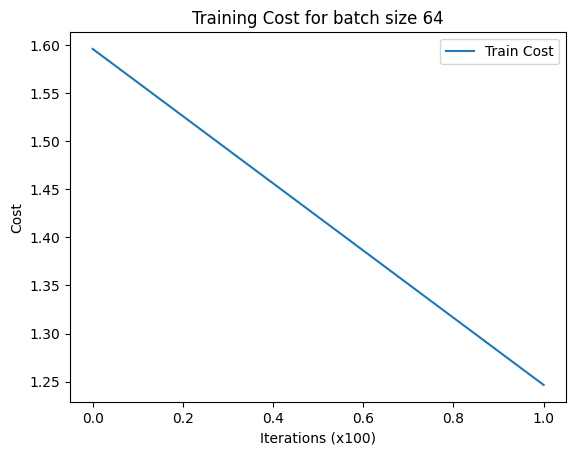

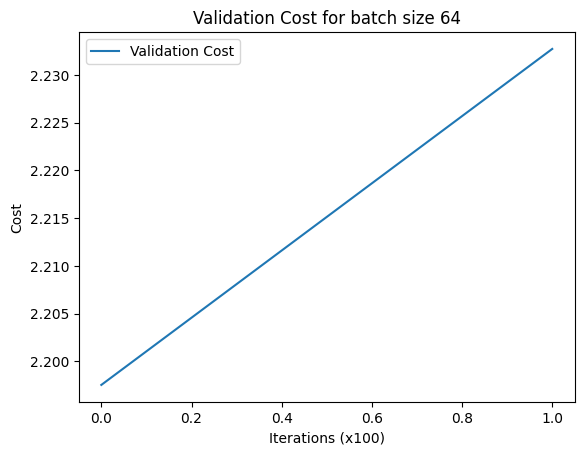

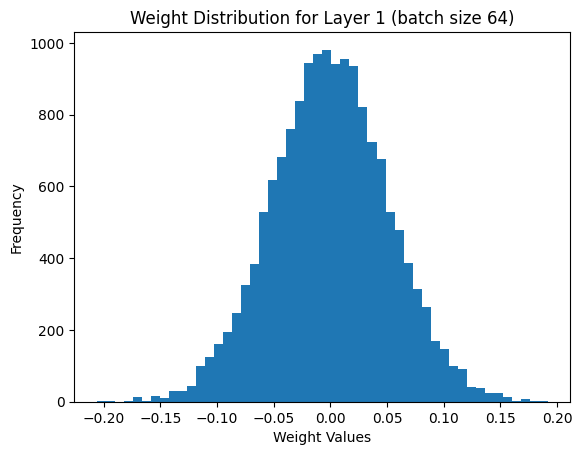

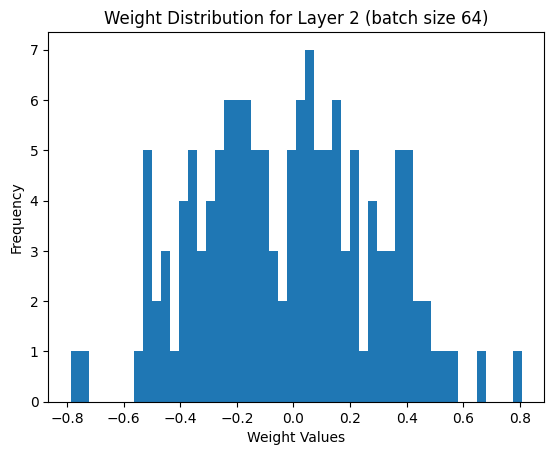

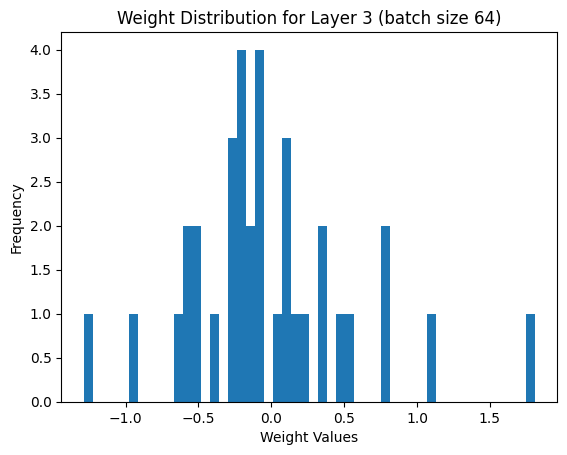

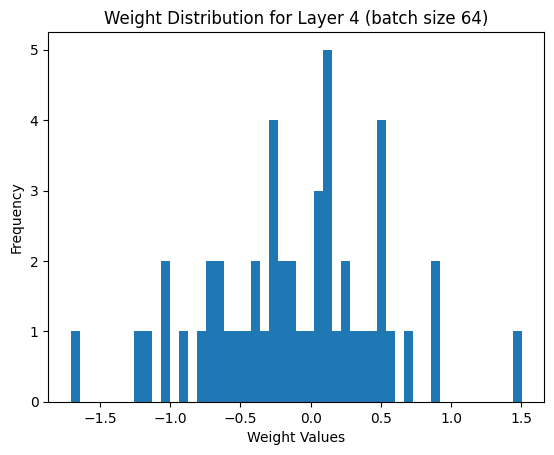

Batch size: 64
Train Accuracy: 0.2764375
Validation Accuracy: 0.27775
Test Accuracy: 0.2761
Final Train Cost: 1.2466069324626399
Final Validation Cost: 2.2327221982378056
------------------------------------------------------------

Epoch number:  1
Cost after iteration 100: 1.602184454626266
Epoch 1, Validation cost after iteration 100: 2.0668330798611128
Cost after iteration 200: 1.426504595844725
Epoch 1, Validation cost after iteration 200: 2.018765757369545
Cost after iteration 300: 1.325399769800554
Epoch 1, Validation cost after iteration 300: 2.0190171007967885
Cost after iteration 400: 1.1503637904615003
Epoch 1, Validation cost after iteration 400: 2.003090099512397
Early stopping triggered after epoch 1, iteration 420
Average cost for epoch 1: 1.3186205311333552


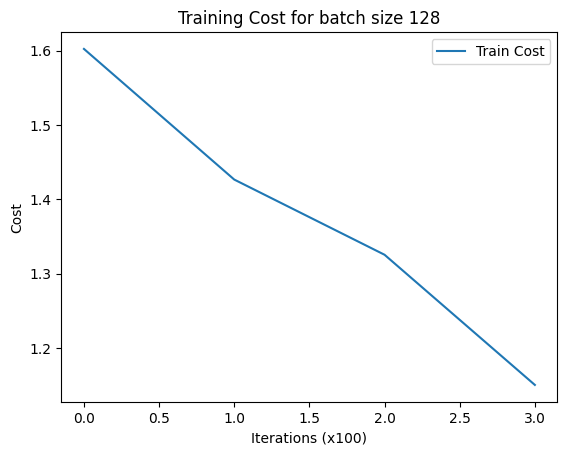

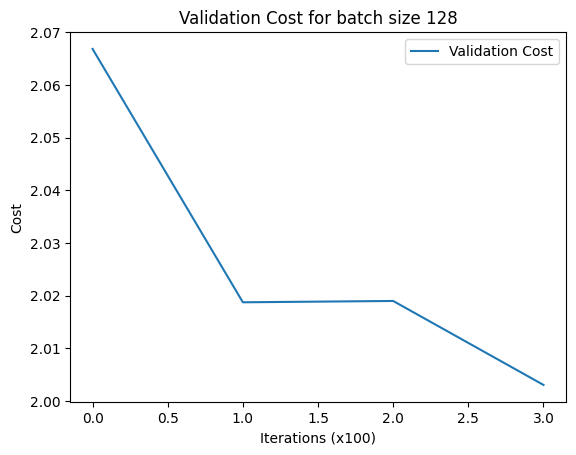

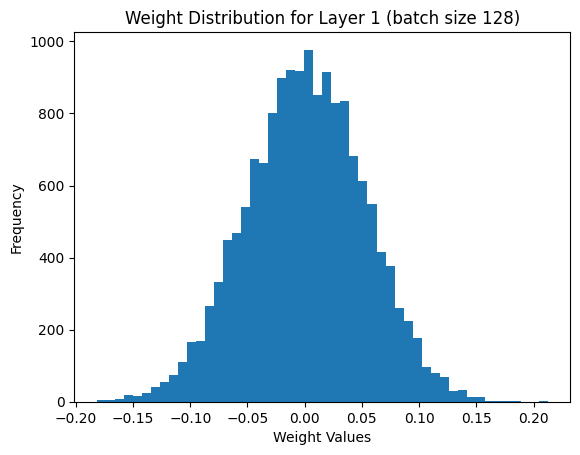

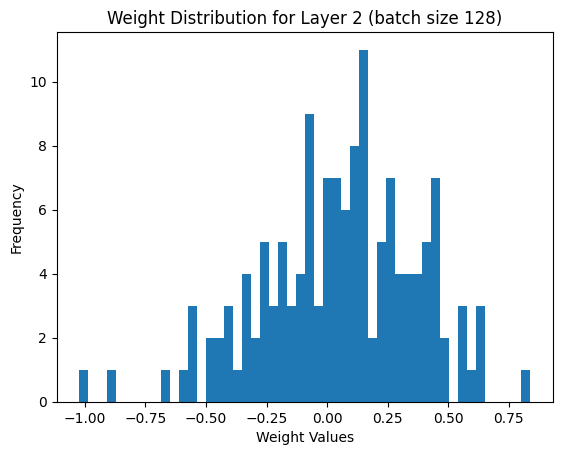

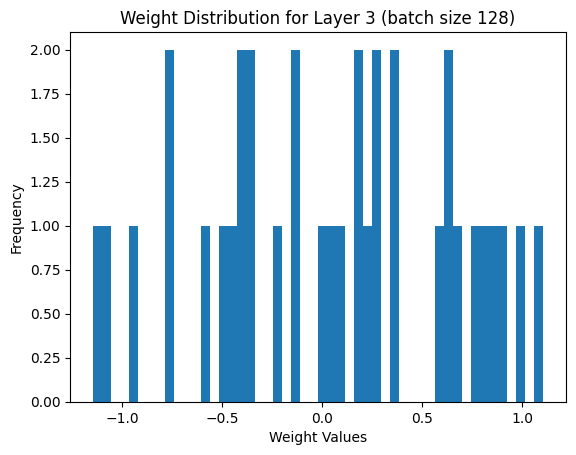

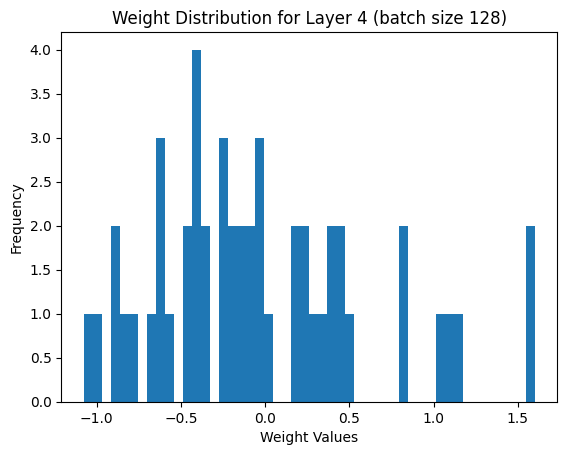

Batch size: 128
Train Accuracy: 0.36264583333333333
Validation Accuracy: 0.3655833333333333
Test Accuracy: 0.3553
Final Train Cost: 1.1503637904615003
Final Validation Cost: 2.003090099512397
------------------------------------------------------------

Epoch number:  1
Cost after iteration 100: 1.8727548549711641
Epoch 1, Validation cost after iteration 100: 2.15944700272081
Cost after iteration 200: 1.640565627548185
Epoch 1, Validation cost after iteration 200: 2.0588744898174474
Average cost for epoch 1: 1.8622639810908999
Epoch number:  2
Cost after iteration 100: 1.355404728987434
Epoch 2, Validation cost after iteration 100: 1.8274875540099658
Cost after iteration 200: 1.048935650042713
Epoch 2, Validation cost after iteration 200: 1.7379683096658682
Average cost for epoch 2: 1.33098568882625
Epoch number:  3
Cost after iteration 100: 1.0726330072476704
Epoch 3, Validation cost after iteration 100: 1.4428016793049658
Cost after iteration 200: 0.9034668604258664
Epoch 3, Validati

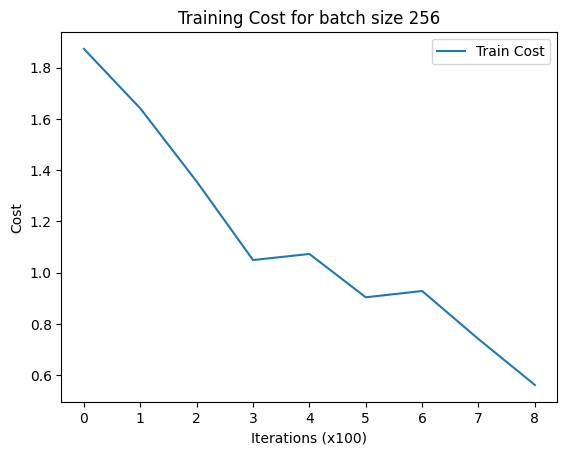

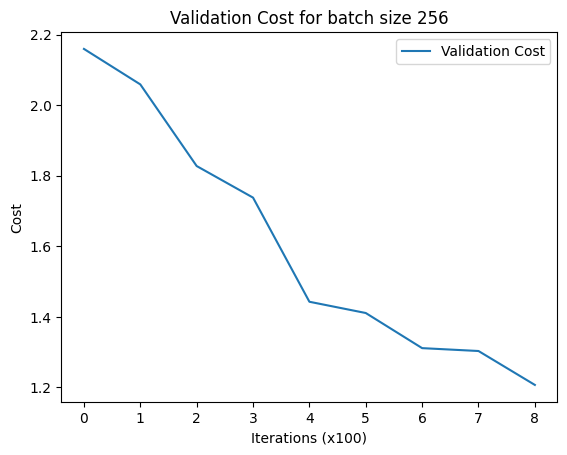

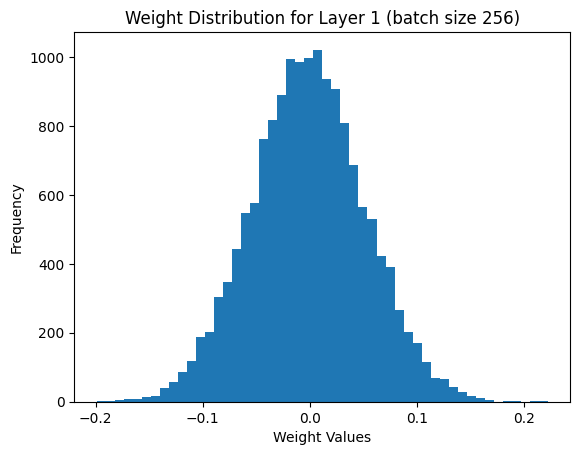

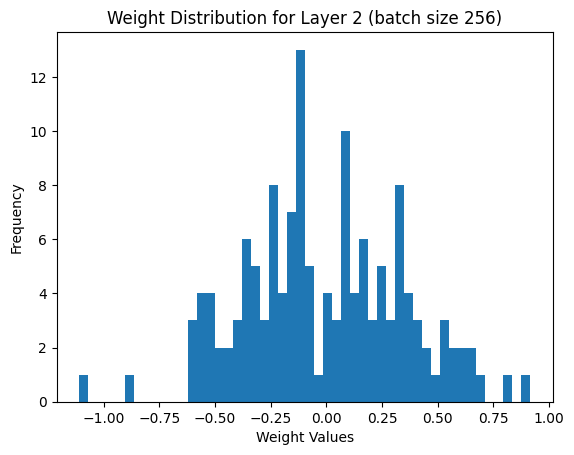

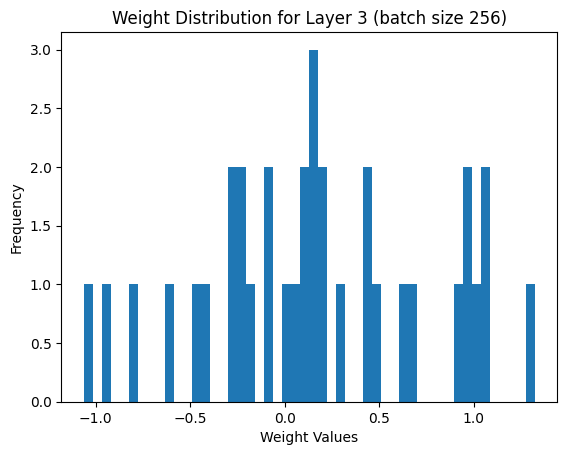

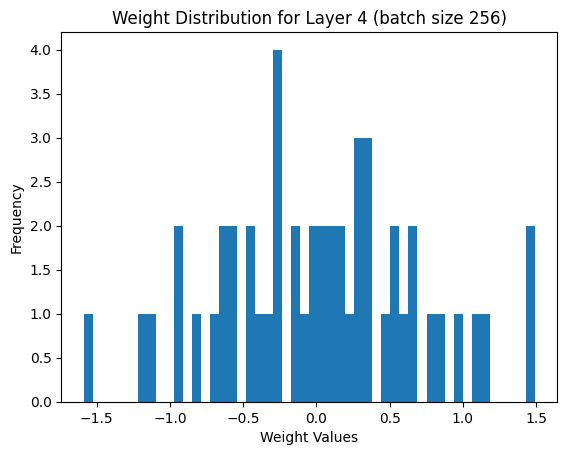

Batch size: 256
Train Accuracy: 0.6481666666666667
Validation Accuracy: 0.6508333333333334
Test Accuracy: 0.6527
Final Train Cost: 0.5615824981979947
Final Validation Cost: 1.2070736143496696
------------------------------------------------------------

Epoch number:  1
Cost after iteration 100: 2.0313260123970016
Epoch 1, Validation cost after iteration 100: 2.1855326791374816
Average cost for epoch 1: 2.1336178325217228
Epoch number:  2
Cost after iteration 100: 1.9085556488597775
Epoch 2, Validation cost after iteration 100: 2.007621080475284
Average cost for epoch 2: 2.036336168907224
Epoch number:  3
Cost after iteration 100: 1.6552510263186817
Epoch 3, Validation cost after iteration 100: 1.8269550090530404
Average cost for epoch 3: 1.752204371772231
Epoch number:  4
Cost after iteration 100: 1.3818905508900983
Epoch 4, Validation cost after iteration 100: 1.6429097744798522
Average cost for epoch 4: 1.5170259488006337
Epoch number:  5
Cost after iteration 100: 1.0626551572327905

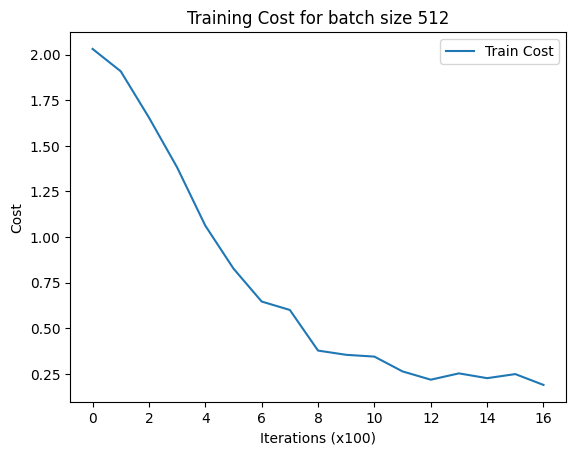

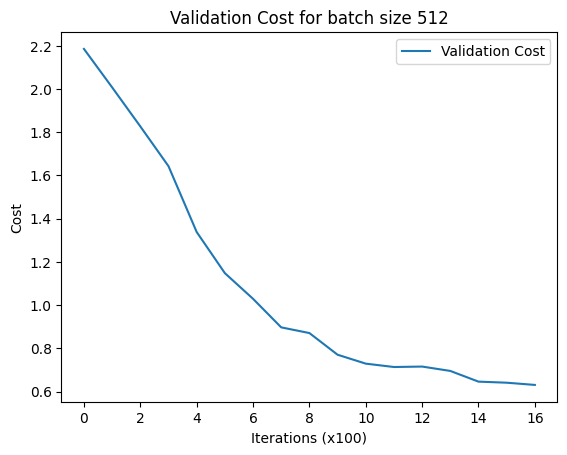

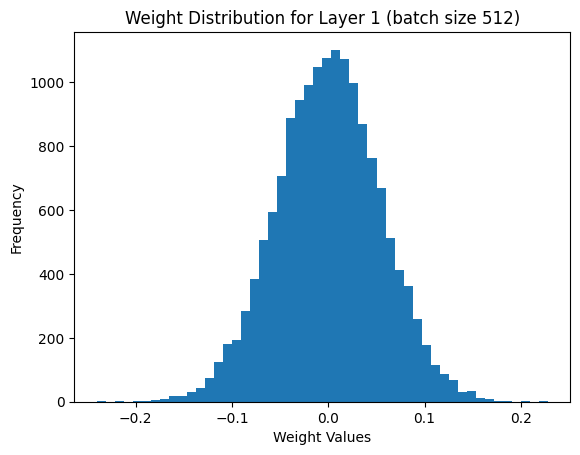

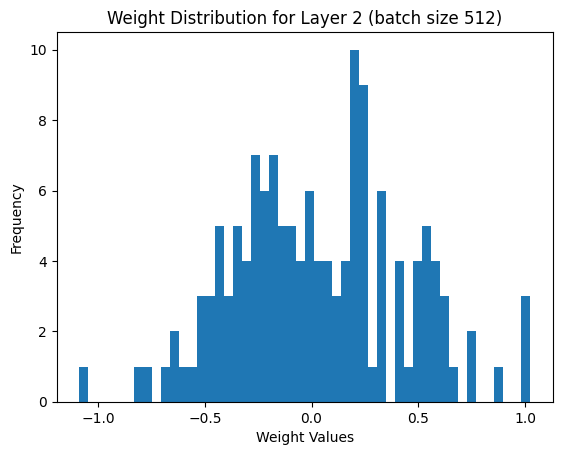

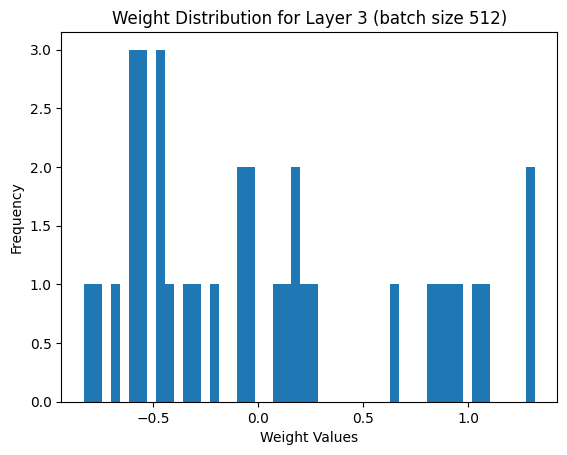

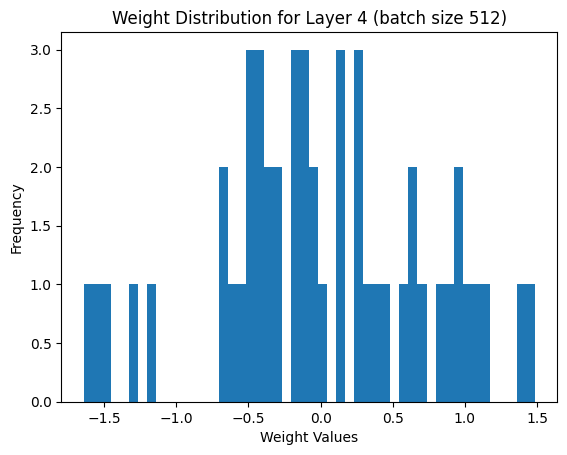

Batch size: 512
Train Accuracy: 0.8472916666666667
Validation Accuracy: 0.8443333333333334
Test Accuracy: 0.846
Final Train Cost: 0.18959556996186805
Final Validation Cost: 0.630690567643919
------------------------------------------------------------



In [ ]:
def run_batch_size_experiment():
  batch_sizes = [64, 128, 256, 512]
  best_results = {}

  for batch_size in batch_sizes:
    best_cost = float('inf')
    best_parameters = None
    best_train_costs = None
    best_average_epoch_costs = None
    best_val_costs = None
    best_train_accuracy = 0
    best_val_accuracy = 0
    best_test_accuracy = 0
    initial_parameters = None
    num_runs = [1]

    for run in num_runs:
      # Load data
      train_loader, test_loader = load_mnist_data()

      # Convert data to numpy arrays
      X_train, Y_train = convert_to_numpy(train_loader)
      X_test, Y_test = convert_to_numpy(test_loader)

      layers_dims = [784, 20, 7, 5, 10]
      learning_rate = 0.009

      num_iterations = math.ceil(X_train.shape[1] / batch_size) # so that every method call of model is 1 epoch: num_iterations = num_batches

      # Train model
      parameters, train_costs, average_epoch_cost, val_costs, train_accuracy, val_accuracy= L_layer_model_for_plotting(X_train, Y_train, layers_dims, learning_rate, num_iterations, batch_size)

      # Evaluate on train, validation, and test sets
      test_accuracy = predict(X_test, Y_test, parameters)

      final_train_cost = train_costs[-1]
      final_val_cost = val_costs[-1]

      if final_val_cost < best_cost:
        best_cost = final_val_cost
        best_parameters = parameters
        best_train_costs = train_costs
        best_average_epoch_costs = average_epoch_cost
        best_val_costs = val_costs
        best_train_accuracy = train_accuracy
        best_val_accuracy = val_accuracy
        best_test_accuracy = test_accuracy

    best_results[batch_size] = {
        'parameters': best_parameters,
        'train_costs': best_train_costs,
        'average_epoch_costs': best_average_epoch_costs,
        'val_costs': best_val_costs,
        'train_accuracy': best_train_accuracy,
        'val_accuracy': best_val_accuracy,
        'test_accuracy': best_test_accuracy,
    }

    # Plotting train costs
    plt.figure()
    plt.plot(best_train_costs, label='Train Cost')
    plt.xlabel('Iterations (x100)')
    plt.ylabel('Cost')
    plt.title(f'Training Cost for batch size {batch_size}')
    plt.legend()
    plt.show()

    # Plotting validation costs and average epoch costs
    plt.figure()
    plt.plot(best_val_costs, label='Validation Cost')
    plt.xlabel('Iterations (x100)')
    plt.ylabel('Cost')
    plt.title(f'Validation Cost for batch size {batch_size}')
    plt.legend()
    plt.show()

    # Plotting weight histograms
    for l in range(1, len(best_parameters) + 1):
      W, b = best_parameters[l]
      plt.figure()
      plt.hist(W.flatten(), bins=50)
      plt.xlabel('Weight Values')
      plt.ylabel('Frequency')
      plt.title(f'Weight Distribution for Layer {l} (batch size {batch_size})')
      plt.show()

    # Print best results for each batch size
    for batch_size, result in best_results.items():
      result_log = (
          f'Batch size: {batch_size}\n'
          f'Train Accuracy: {result["train_accuracy"]}\n'
          f'Validation Accuracy: {result["val_accuracy"]}\n'
          f'Test Accuracy: {result["test_accuracy"]}\n'
          f'Final Train Cost: {result["train_costs"][-1]}\n'
          f'Final Validation Cost: {result["val_costs"][-1]}\n'
          '------------------------------------------------------------\n'
      )

    print(result_log)

    append_to_log_file(f'results_{batch_size}.txt', result_log)

run_batch_size_experiment()

Epoch number:  1


<ipython-input-15-ead51f027de7>:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  dZ = softmax_probabilities - dA


Cost after iteration 100: 2.0506683481052366
Epoch 1, Validation cost after iteration 100: 2.135399412716415
Average cost for epoch 1: 2.147537462017547
Epoch number:  2
Cost after iteration 100: 1.8855231412793403
Epoch 2, Validation cost after iteration 100: 2.0266747577342943
Average cost for epoch 2: 1.9570196157274788
Epoch number:  3
Cost after iteration 100: 1.6676566849115029
Epoch 3, Validation cost after iteration 100: 1.8592482878177716
Average cost for epoch 3: 1.7889959928855939
Epoch number:  4
Cost after iteration 100: 1.486293680243591
Epoch 4, Validation cost after iteration 100: 1.6671263242653807
Average cost for epoch 4: 1.592394104603341
Epoch number:  5
Cost after iteration 100: 1.2791186146225269
Epoch 5, Validation cost after iteration 100: 1.5159986000528922
Average cost for epoch 5: 1.3737083534261088
Epoch number:  6
Cost after iteration 100: 1.2219039667211928
Epoch 6, Validation cost after iteration 100: 1.3848430430118028
Average cost for epoch 6: 1.304473

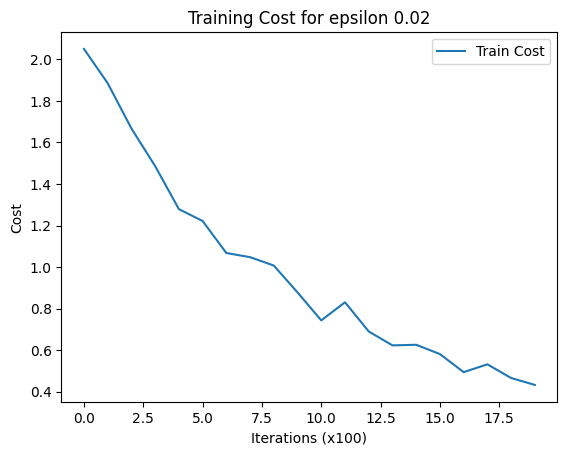

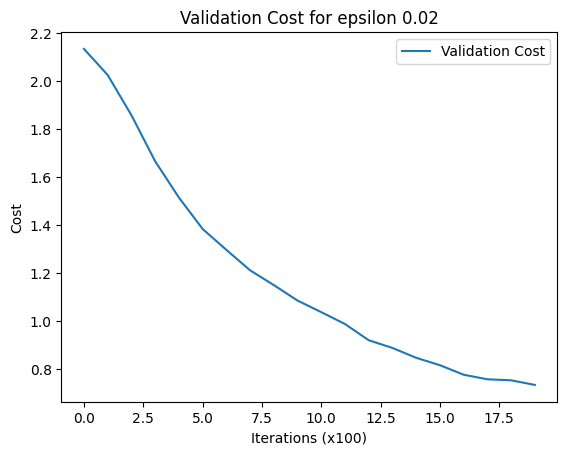

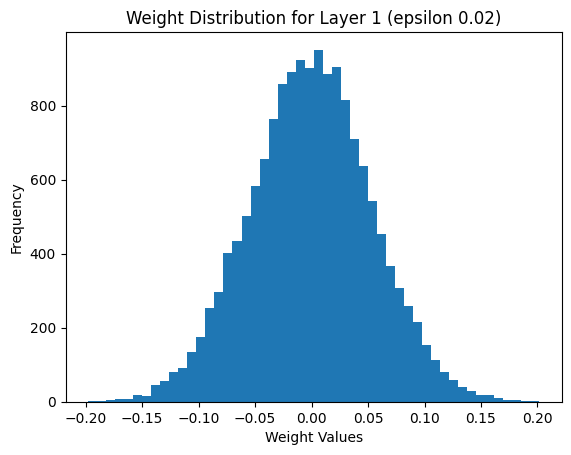

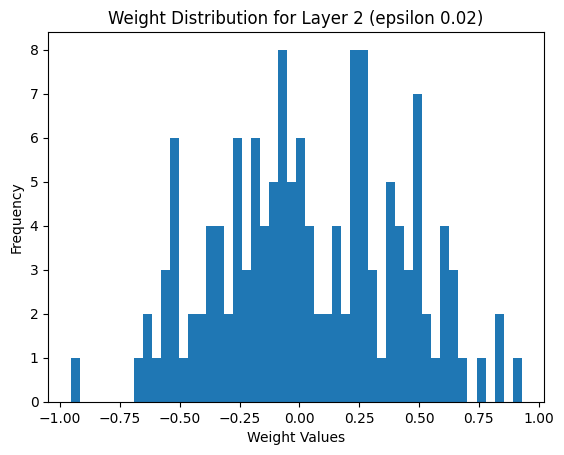

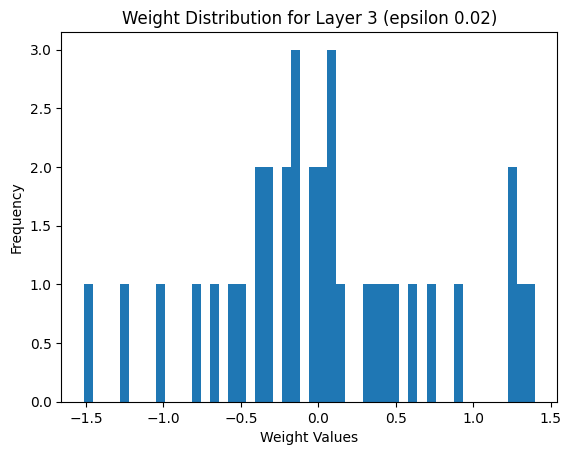

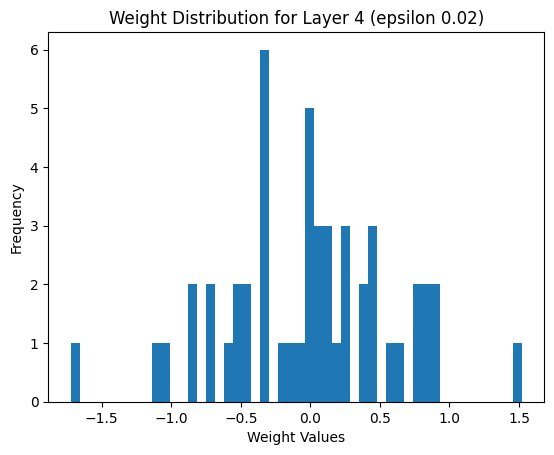

Batch size: 0.02
Train Accuracy: 0.7851458333333333
Validation Accuracy: 0.7839166666666667
Test Accuracy: 0.7817
Final Train Cost: 0.4324434726221446
Final Validation Cost: 0.7347843511475627
------------------------------------------------------------

Epoch number:  1
Cost after iteration 100: 1.9472447826881283
Epoch 1, Validation cost after iteration 100: 2.0840117521795123
Average cost for epoch 1: 2.1072452942935467
Epoch number:  2
Cost after iteration 100: 1.693147252350359
Epoch 2, Validation cost after iteration 100: 1.8683436174470307
Average cost for epoch 2: 1.8053660064172685
Epoch number:  3
Cost after iteration 100: 1.4469224374714829
Epoch 3, Validation cost after iteration 100: 1.6282065788464517
Average cost for epoch 3: 1.5831257284837943
Epoch number:  4
Cost after iteration 100: 1.3285253685528937
Epoch 4, Validation cost after iteration 100: 1.4482411884454993
Average cost for epoch 4: 1.4532982358018396
Epoch number:  5
Cost after iteration 100: 0.9858127834261

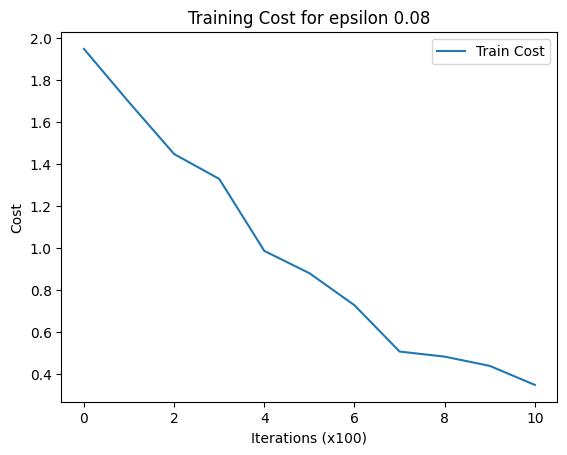

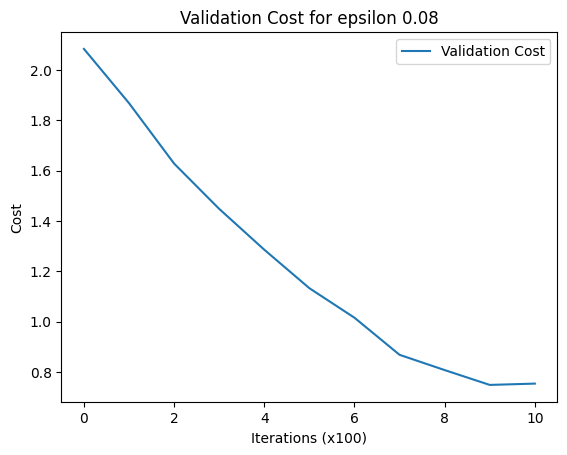

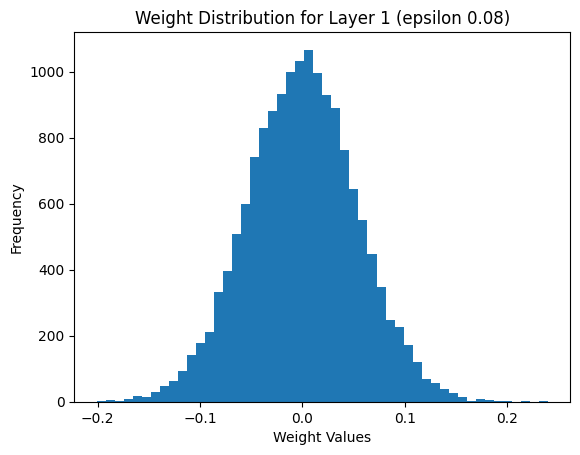

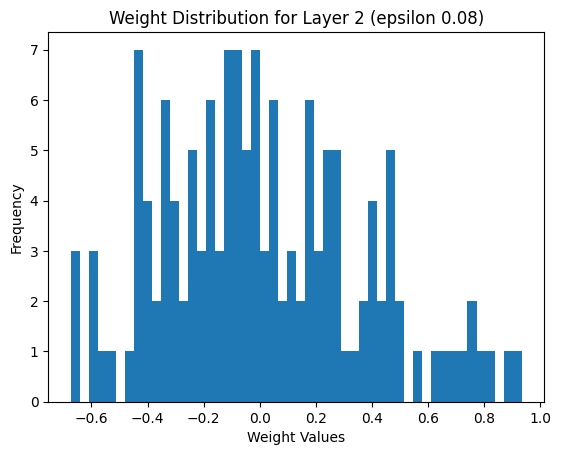

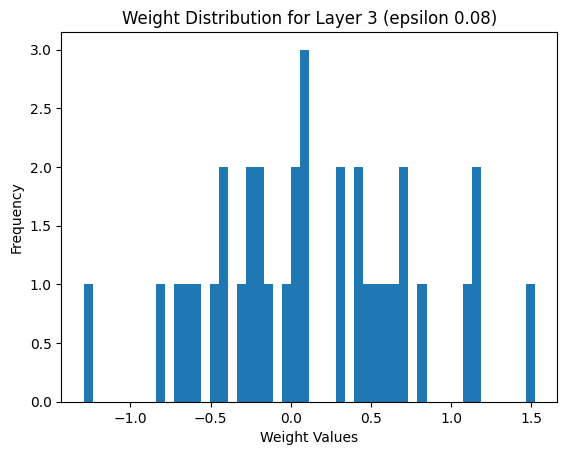

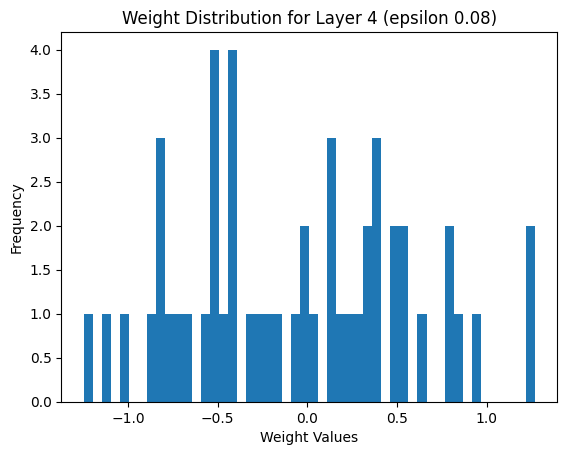

Batch size: 0.08
Train Accuracy: 0.8065416666666667
Validation Accuracy: 0.8089166666666666
Test Accuracy: 0.8126
Final Train Cost: 0.3479589354757987
Final Validation Cost: 0.753931280934186
------------------------------------------------------------

Epoch number:  1
Cost after iteration 100: 1.732279195321474
Epoch 1, Validation cost after iteration 100: 1.9167800129490218
Average cost for epoch 1: 1.9413370398201173
Epoch number:  2
Cost after iteration 100: 1.5168515908984137
Epoch 2, Validation cost after iteration 100: 1.626357167117297
Average cost for epoch 2: 1.6450829775713562
Epoch number:  3
Cost after iteration 100: 1.3266434624133416
Epoch 3, Validation cost after iteration 100: 1.4329572601645746
Average cost for epoch 3: 1.4360945210223555
Epoch number:  4
Cost after iteration 100: 1.1388473314015923
Epoch 4, Validation cost after iteration 100: 1.3145015954585144
Average cost for epoch 4: 1.2323350614516266
Epoch number:  5
Cost after iteration 100: 1.019862694269307

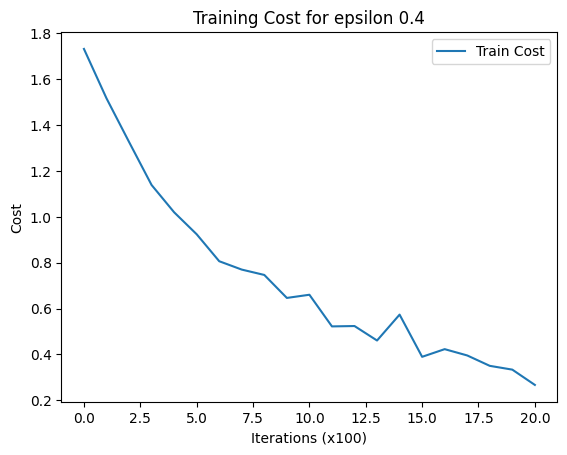

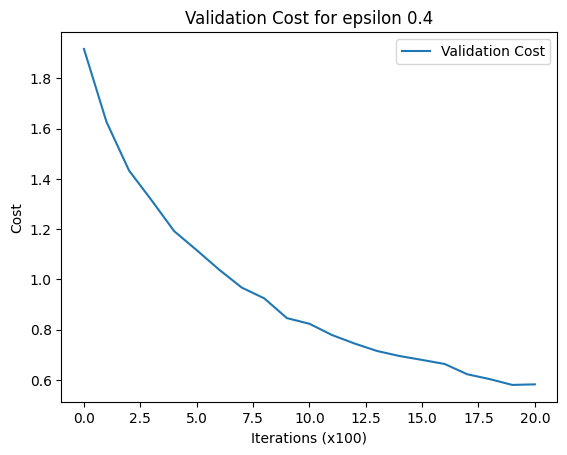

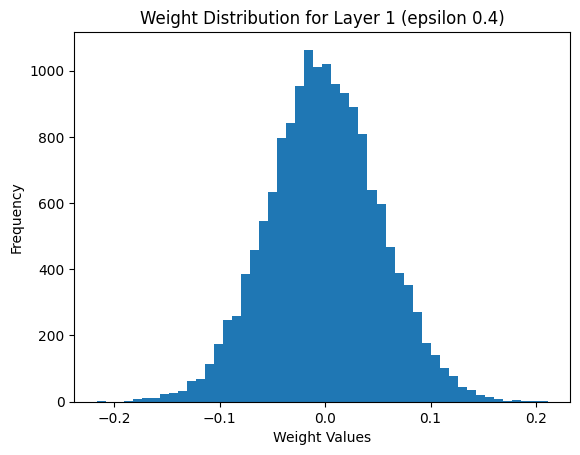

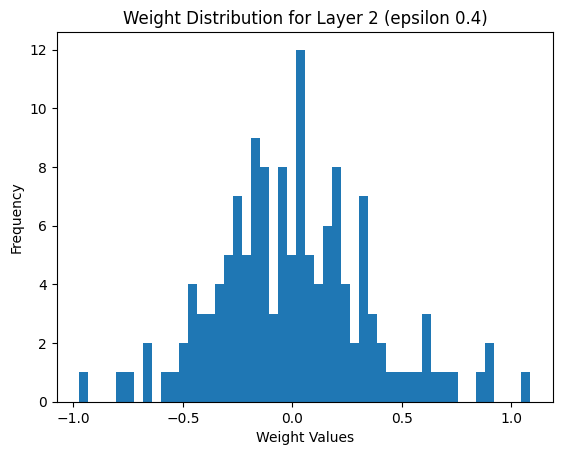

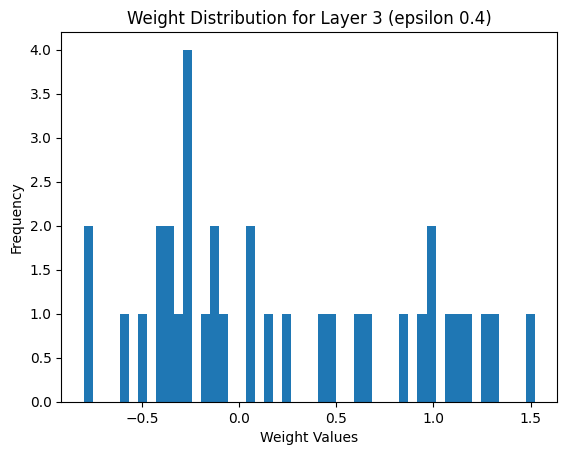

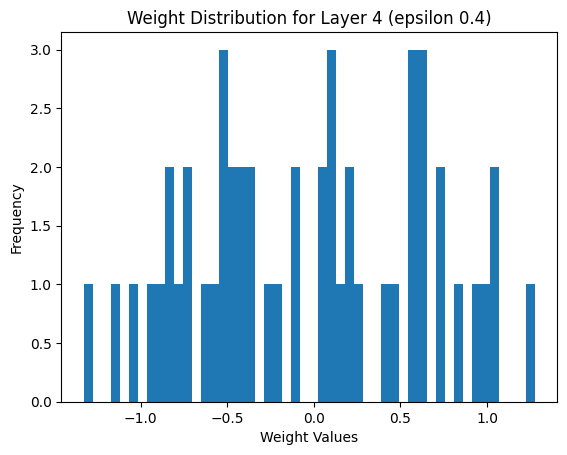

Batch size: 0.4
Train Accuracy: 0.8536458333333333
Validation Accuracy: 0.851
Test Accuracy: 0.8604
Final Train Cost: 0.2669753721824364
Final Validation Cost: 0.5821869392866003
------------------------------------------------------------



In [ ]:
def run_epsilon_value_experiment():
  epsilon = [0.02, 0.08, 0.4]
  best_results = {}

  for e in epsilon:
    best_cost = float('inf')
    best_parameters = None
    best_train_costs = None
    best_average_epoch_costs = None
    best_val_costs = None
    best_train_accuracy = 0
    best_val_accuracy = 0
    best_test_accuracy = 0
    initial_parameters = None
    num_runs = [1]

    for run in num_runs:
      # Load data
      train_loader, test_loader = load_mnist_data()

      # Convert data to numpy arrays
      X_train, Y_train = convert_to_numpy(train_loader)
      X_test, Y_test = convert_to_numpy(test_loader)

      layers_dims = [784, 20, 7, 5, 10]
      learning_rate = 0.009
      batch_size = 512

      num_iterations = math.ceil(X_train.shape[1] / batch_size) # so that every method call of model is 1 epoch: num_iterations = num_batches

      # Train model
      parameters, train_costs, average_epoch_cost, val_costs, train_accuracy, val_accuracy = L_layer_model_for_plotting(
          X_train, Y_train, layers_dims, learning_rate, num_iterations, batch_size, epsilon=e)

      # Evaluate on train, validation, and test sets
      test_accuracy = predict(X_test, Y_test, parameters)

      final_train_cost = train_costs[-1]
      final_val_cost = val_costs[-1]

      if final_val_cost < best_cost:
        best_cost = final_val_cost
        best_parameters = parameters
        best_train_costs = train_costs
        best_average_epoch_costs = average_epoch_cost
        best_val_costs = val_costs
        best_train_accuracy = train_accuracy
        best_val_accuracy = val_accuracy
        best_test_accuracy = test_accuracy

    best_results[e] = {
        'parameters': best_parameters,
        'train_costs': best_train_costs,
        'average_epoch_costs': best_average_epoch_costs,
        'val_costs': best_val_costs,
        'train_accuracy': best_train_accuracy,
        'val_accuracy': best_val_accuracy,
        'test_accuracy': best_test_accuracy,
    }

    # Plotting train costs
    plt.figure()
    plt.plot(best_train_costs, label='Train Cost')
    plt.xlabel('Iterations (x100)')
    plt.ylabel('Cost')
    plt.title(f'Training Cost for epsilon {e}')
    plt.legend()
    plt.show()

    # Plotting validation costs and average epoch costs
    plt.figure()
    plt.plot(best_val_costs, label='Validation Cost')
    plt.xlabel('Iterations (x100)')
    plt.ylabel('Cost')
    plt.title(f'Validation Cost for epsilon {e}')
    plt.legend()
    plt.show()

    # Plotting weight histograms
    for l in range(1, len(best_parameters) + 1):
      W, b = best_parameters[l]
      plt.figure()
      plt.hist(W.flatten(), bins=50)
      plt.xlabel('Weight Values')
      plt.ylabel('Frequency')
      plt.title(f'Weight Distribution for Layer {l} (epsilon {e})')
      plt.show()

    # Print best results for each epsilon
    for batch_size, result in best_results.items():
      result_log = (
          f'Batch size: {batch_size}\n'
          f'Train Accuracy: {result["train_accuracy"]}\n'
          f'Validation Accuracy: {result["val_accuracy"]}\n'
          f'Test Accuracy: {result["test_accuracy"]}\n'
          f'Final Train Cost: {result["train_costs"][-1]}\n'
          f'Final Validation Cost: {result["val_costs"][-1]}\n'
          '------------------------------------------------------------\n'
      )

    print(result_log)

run_epsilon_value_experiment()

## 8. Batchnorm + L2 Regularization

In [ ]:
run_L_layer_model(use_batchnorm=True, epsilon=0.4)

Epoch number:  1


<ipython-input-15-ead51f027de7>:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  dZ = softmax_probabilities - dA


Cost after iteration 100: 2.118011925667722
Epoch 1, Validation cost after iteration 100: 2.1938029371930106
Average cost for epoch 1: 2.213517057052547
Epoch number:  2
Cost after iteration 100: 1.8437024108119586
Epoch 2, Validation cost after iteration 100: 1.9200587597861334
Average cost for epoch 2: 1.960657648225441
Epoch number:  3
Cost after iteration 100: 1.55917171848194
Epoch 3, Validation cost after iteration 100: 1.7280482736034057
Average cost for epoch 3: 1.6600278321784818
Epoch number:  4
Cost after iteration 100: 1.516030845701499
Epoch 4, Validation cost after iteration 100: 1.6208574086109253
Average cost for epoch 4: 1.5845482547557375
Epoch number:  5
Cost after iteration 100: 1.3946533372277377
Epoch 5, Validation cost after iteration 100: 1.5239423636761855
Average cost for epoch 5: 1.4770437406788306
Epoch number:  6
Cost after iteration 100: 1.344881685042765
Epoch 6, Validation cost after iteration 100: 1.4075340115246773
Average cost for epoch 6: 1.417038330